# Sporulation

In [5]:
from __future__ import print_function, division, absolute_import

import sys

import qminospy
from qminospy.me2 import ME_NLP
import os

# python imports
from copy import copy
import re
from os.path import join, dirname, abspath
import sys
from collections import defaultdict
import pickle

# third party imports
import pandas as pd
import cobra
from tqdm import tqdm
import numpy as np
import scipy

# COBRAme
import cobrame
from cobrame.util import building, mu, me_model_interface
from cobrame.io.json import save_json_me_model, save_reduced_json_me_model

# ECOLIme
import bacillusme
from bacillusme import (transcription, translation, flat_files, generics, formulas, compartments)
from cobrame.util.helper_functions import *

import copy
from scipy import stats
import matplotlib.pyplot as plt
%load_ext autoreload
%autoreload 2
ecoli_files = dirname(abspath(bacillusme.__file__))
pd.set_option('display.max_colwidth', None)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
/home/jt/work/cobrapy-0.5.11/cobra/__init__.py
/home/jt/work/cobrame/cobrame/__init__.py
/home/jt/work/sporeme/bacillusme/__init__.py


## Analysis
___

### Gene interdependence

In [31]:
locus_to_name = pd.read_csv('./gene_name_dictionary.csv',index_col=0)['name'].to_dict()
name_to_locus = pd.read_csv('./gene_name_dictionary.csv',index_col=1)['locus_id'].to_dict()

In [263]:
FS_df = pd.read_csv('essentiality_raw_results_naive_FS_transport_spoAQ.csv',index_col=0).T
VG_df = pd.read_csv('./essentiality/vegetative/essentiality_raw_me_results.csv',index_col=0).T

In [419]:
cutoff = 1e-16 # Tolerance for any flux
# growth_cutoff = df['biomass_dilution']['base'] * 0.1 # 10% or lower growth rate = no growth
growth_cutoff = 1e-3
translation = FS_df[FS_df['biomass_dilution_s']>=growth_cutoff][[i for i in FS_df.columns if re.search('translation_.*_s',i)]].T
active_base = translation[translation['base']>=cutoff].T.drop('base')
inactive_base = translation[translation['base']<cutoff].T.drop('base')

In [420]:
essential_genes = list(FS_df[FS_df['biomass_dilution_s']<growth_cutoff].index)
VG_essential_genes = list(VG_df[VG_df['biomass_dilution']<growth_cutoff].index)
active_genes = [locus_to_name[g.split('translation_')[1].split('_s')[0]] for g in active_base.columns if "dummy" not in g]

In [421]:
id_dep = defaultdict(list)
name_dep = defaultdict(list)
fwd_id_dep = defaultdict(list)
fwd_name_dep = defaultdict(list)
for g,row in active_base.iterrows():
    g = g.split('_s')[0]
    gname = locus_to_name[g]
    for i,_ in row[row<cutoff].items():
        gene = i.split('translation_')[1].split('_s')[0]
        gene_name = locus_to_name[gene]
        
        id_dep[gene].append(g)
        name_dep[gene_name].append(gname)
        
        fwd_id_dep[g].append(gene)
        fwd_name_dep[gname].append(gene_name)
        

### To table

In [498]:
def get_partitioning(gene):
    # gene = name_to_locus[name]
    tmp = sporeme.solution.x_dict
    fs = tmp["translation_{}_s".format(gene)]
    mc = tmp["translation_{}".format(gene)]
    return fs/(fs+mc)

dct = {}
for i in FS_df.dropna().drop("base").index:
    i = i.split("_s")[0]
    dct[locus_to_name[i]] = get_partitioning(i)
partitioning = pd.DataFrame.from_dict({"val":dct}).fillna(0.)["val"].to_dict()

/home/jt/venvs/python3.7-cobrame/lib/python3.7/site-packages/ipykernel_launcher.py:6 RuntimeWarning: invalid value encountered in double_scalars


In [494]:
with open("./sporeme_solution_v4_proteomics_spoAQ.pickle", "rb") as outfile:
    sporeme = pickle.load(outfile)

In [518]:
dct = {}
counter = 0
for i,jlist in fwd_name_dep.items():
    # if partitioning.get(i,0) > 0.9:
    #     continue
    for j in jlist:
        # if partitioning.get(j,0) > 0.9:
        #     continue
        tmp = {
            "SOURCE" : i,
            "TARGET" : j
        }
        dct[counter] = tmp
        counter += 1

In [519]:
pd.DataFrame.from_dict(dct).T.set_index("SOURCE").to_csv("./cytoscape/inactivation.csv")

## Known depletions neighborhood

In [510]:
def get_edges_from_gene(gene):
    edges = set()
    for j in fwd_name_dep[gene]:
        if j==gene: continue
        edges.add((gene,j))
    for j in name_dep[gene]:
        if j==gene: continue
        edges.add((j,gene))
    return edges

def get_graph_from_gene(gene):
    import networkx as nx
    import matplotlib.pyplot as plt
    plt.rcParams['svg.fonttype'] = 'none'
    G = nx.DiGraph()
    edges = get_edges_from_gene(gene)
    for i,j in edges:
        G.add_edge(i,j)
    return G

In [520]:
known_depletions = [g[0].lower() + g[1:] for g in list(pd.read_csv('proteomics/known_depletions.txt')['protein'].values)]
confirmed_depletions = ['pckA','purL','ilvB','ilvE','citZ','acsA','etfA','acoC','sigF','yxbC','lutC',
                  'argJ','hpf']

In [522]:
len(set(known_depletions)-set(confirmed_depletions))

76

In [511]:
# known_depletions = [i for i in known_depletions if i != "citZ"]
known_depletions = [i for i in confirmed_depletions]

In [512]:
# importing networkx
import networkx as nx
# importing matplotlib.pyplot
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
G = nx.DiGraph()
edges = set()
for j in known_depletions:
    e = get_edges_from_gene(j)
    edges = edges | e
for i,j in edges:
    G.add_edge(i,j)

In [513]:
color_map = []
degree = []
labels = {}
for node in G:
    d = len(fwd_name_dep[node])
    degree.append(d)
    name = locus_to_name[node] if node in locus_to_name else node
    if name in confirmed_depletions:
        color_map.append('green')
    elif name in res_df.index:
        color_map.append('blue')
    else: 
        color_map.append('gray')
#     if d > 5:
    labels[node] = locus_to_name[node] if node in locus_to_name else node

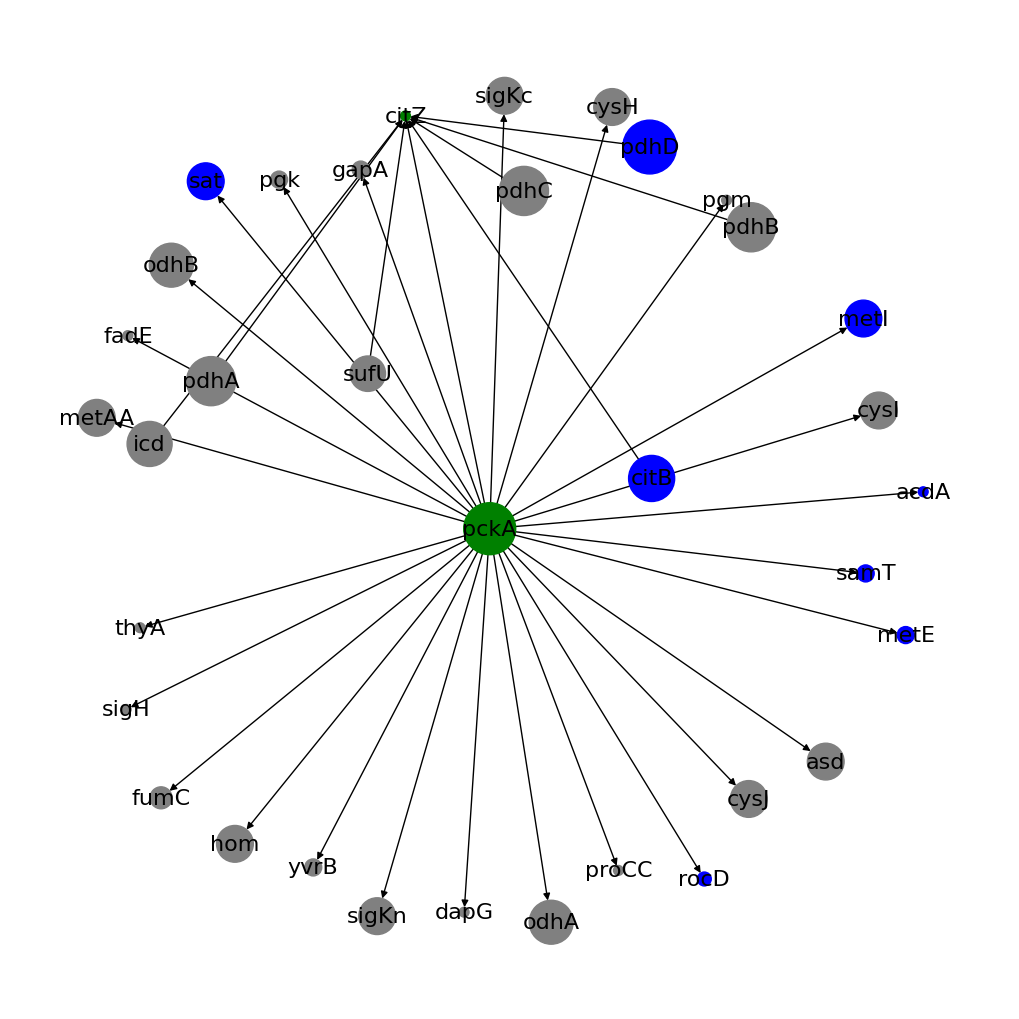

In [514]:
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k=1.)
nx.draw(G,
       pos=pos,
       node_color=color_map,
       node_size=[i*50 for i in degree])
_ = nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='k')
# plt.savefig('./figures/network_gene_interdependence_spring_fwd_genome.svg',format='SVG')

In [437]:
affected_by_confirmed = set(G.nodes) - set(["citZ","pckA"])

In [438]:
fwd_name_dep["sigKc"]

['samT',
 'metI',
 'metE',
 'cysH',
 'sat',
 'asd',
 'dapG',
 'metAA',
 'sigKn',
 'sigKc',
 'hom',
 'yvrB',
 'cysI',
 'cysJ']

In [290]:
# importing networkx
import networkx as nx
# importing matplotlib.pyplot
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
G = nx.DiGraph()
edges = set()
for j in affected_by_confirmed:
    e = get_edges_from_gene(j)
    edges = edges | e
for i,j in edges:
    G.add_edge(i,j)

In [291]:
color_map = []
degree = []
labels = {}
for node in G:
    d = len(fwd_name_dep[node])
    degree.append(d)
    name = locus_to_name[node] if node in locus_to_name else node
    if name in confirmed_depletions:
        color_map.append('green')
    elif name in res_df.index:
        color_map.append('blue')
    else: 
        color_map.append('gray')
#     if d > 5:
    labels[node] = locus_to_name[node] if node in locus_to_name else node

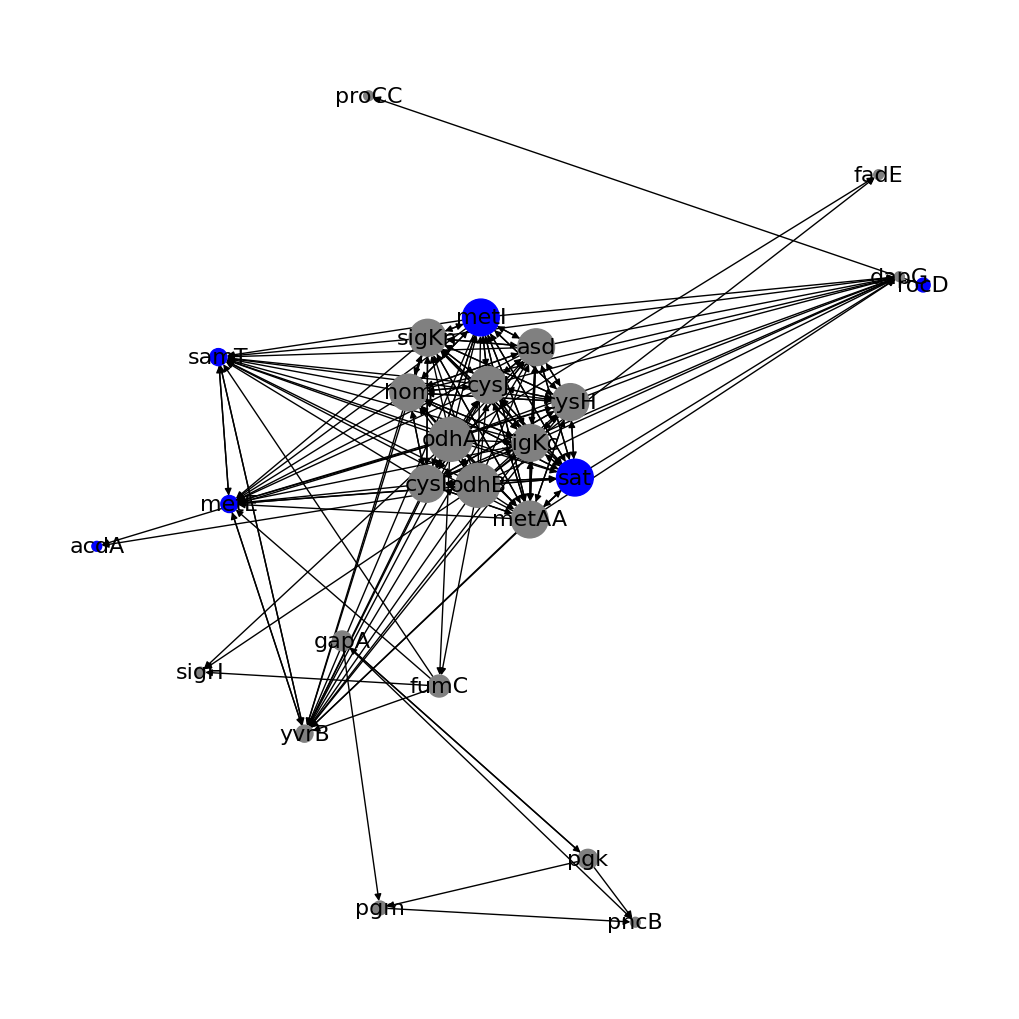

In [292]:
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k=1.)
nx.draw(G,
       pos=pos,
       node_color=color_map,
       node_size=[i*50 for i in degree])
_ = nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='k')
# plt.savefig('./figures/network_gene_interdependence_spring_fwd_genome.svg',format='SVG')

In [293]:
pd.DataFrame.from_dict({'locus':{i:name_to_locus[i] for i in G.nodes}}).to_csv('confirmed_depletion_neighborhood_spoAQ.txt',header=None)

### Known depletions

In [439]:
known_depletions = [g[0].lower() + g[1:] for g in list(pd.read_csv('proteomics/known_depletions.txt')['protein'].values)]
confirmed_depletions = ['pckA','purL','ilvB','ilvE','citZ','acsA','etfA','acoC','sigF','yxbC','lutC',
                  'argJ','hpf']

In [440]:
res = {}
for g in known_depletions:
    locus = name_to_locus[g]
    dep_genes = [i for i in id_dep[locus]]
    res[g] = {
        'locus_id':locus,
        'in_model':'RNA_'+locus in sporeme.metabolites,
        'FS_essential':locus+'_s' in essential_genes,
        'VG_essential':locus in VG_essential_genes,
        'active':locus in active_genes,
        'depends on':', '.join([locus_to_name[i] if i in locus_to_name else i for i in dep_genes])
    }

In [441]:
res_df = pd.DataFrame.from_dict(res).T.sort_index()

In [442]:
res_df.to_csv('proteomics/dependence_results_transport_spoAQ.csv')

In [443]:
res_df.sort_values('depends on',ascending=False).head(20)

locus_id in_model FS_essential VG_essential active  \
samT   BSU11010     True        False         True  False   
metE   BSU13180     True        False         True  False   
citZ   BSU29140     True        False        False  False   
ilvC   BSU28290     True        False         True  False   
acdA   BSU37170     True        False        False  False   
citB   BSU18000     True        False        False  False   
rocD   BSU40340     True        False        False  False   
sucD   BSU16100     True        False        False  False   
sucC   BSU16090     True        False        False  False   
sigE   BSU15320     True        False        False  False   
pdhD   BSU14610     True        False        False  False   
pckA   BSU30560     True        False        False  False   
mdh    BSU29120     True        False        False  False   
fadN   BSU32840     True        False        False  False   
sat    BSU15590     True        False         True  False   
metI   BSU11870     True        False         True  False   
carB   BSU11240     True        False        False  False   
pyrAA  BSU15510     True        False        False  False   
skfB   BSU01920    False        False        False  False   
sigF   BSU23450     True         True        False  False   

                                                                                                                                                                           depends on  
samT   yvrB, glnA, glmS, metE, aspB, cmk, metI, hom, sucD, sucC, samT, adk, fumC, metAA, cysH, sat, asd, pdhC, pdhB, pdhA, sigKc, sigKn, cysJ, cysI, pckA, citB, mdh, icd, odhA, odhB  
metE   yvrB, glnA, glmS, metE, aspB, cmk, metI, hom, sucD, sucC, samT, adk, fumC, metAA, cysH, sat, asd, pdhC, pdhB, pdhA, sigKc, sigKn, cysJ, cysI, pckA, citB, mdh, icd, odhA, odhB  
citZ                                                                                                                              sufU, pdhC, pdhB, pdhD, pdhA, pckA, citB, citZ, icd  
ilvC                                                                                                                                   sufU, mccB, mccA, maeB, trxA, pdhD, ilvD, ilvC  
acdA                                                                                                sufU, fadA, fadN, sigE, pdhC, pdhB, pdhD, pdhA, pckA, citB, icd, acdA, odhA, odhB  
citB                                                                                                                                                                       sufU, citB  
rocD                                                                                                                                         sucD, sucC, pdhC, pdhB, pdhA, rocD, pckA  
sucD                                                                                                                                                                       sucD, sucC  
sucC                                                                                                                                                                       sucD, sucC  
sigE                                                                                                                                                                             sigE  
pdhD                                                                                                                                                                             pdhD  
pckA                                                                                                                                                                             pckA  
mdh                                                                                                                                                                               mdh  
fadN                                                                                                                                                 

### Essential in FS

sigB is essential because it regulates synthesis of teichoic acid for biomass component tcam_BS_c. BsubCyc shows it is not essential but the model requires it for cell wall synthesis.

In [44]:
res_df[res_df['FS_essential']>0]

locus_id in_model FS_essential VG_essential active depends on
sigB  BSU04730     True         True         True   True           
sigF  BSU23450     True         True        False   True

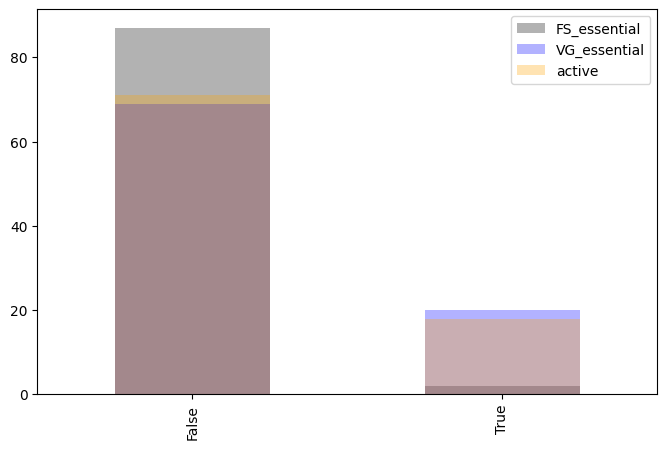

In [45]:
# None of them are essential
fig, ax = plt.subplots(figsize=(8,5))
res_df['FS_essential'].value_counts().plot.bar(ax=ax,color='k',alpha=0.3)
res_df['VG_essential'].value_counts().plot.bar(ax=ax,color='b',alpha=0.3)
res_df['active'].value_counts().plot.bar(ax=ax,color='orange',alpha=0.3)
plt.legend()
plt.savefig('./figures/gene_interdependence_stats_transport_spoAQ.svg',format='SVG')

In [46]:
res_df['active'].value_counts()

False    71
True     18
Name: active, dtype: int64

In [47]:
res_df[res_df['active']==True]

locus_id in_model FS_essential VG_essential active  \
acdA  BSU37170     True        False        False   True   
citB  BSU18000     True        False        False   True   
citZ  BSU29140     True        False        False   True   
fadN  BSU32840     True        False        False   True   
ilvC  BSU28290     True        False         True   True   
mdh   BSU29120     True        False        False   True   
metE  BSU13180     True        False         True   True   
metI  BSU11870     True        False         True   True   
pckA  BSU30560     True        False        False   True   
pdhD  BSU14610     True        False        False   True   
rocD  BSU40340     True        False        False   True   
samT  BSU11010     True        False         True   True   
sat   BSU15590     True        False         True   True   
sigB  BSU04730     True         True         True   True   
sigE  BSU15320     True        False        False   True   
sigF  BSU23450     True         True        False   True   
sucC  BSU16090     True        False        False   True   
sucD  BSU16100     True        False        False   True   

                                                                                                                                                                          depends on  
acdA                                                                                               sufU, fadA, fadN, sigE, pdhC, pdhB, pdhD, pdhA, pckA, citB, icd, acdA, odhA, odhB  
citB                                                                                                                                                                      sufU, citB  
citZ                                                                                                                             sufU, pdhC, pdhB, pdhD, pdhA, pckA, citB, citZ, icd  
fadN                                                                                                                                                                fadA, fadN, sigE  
ilvC                                                                                                                                  sufU, mccB, mccA, maeB, trxA, pdhD, ilvD, ilvC  
mdh                                                                                                                                                                              mdh  
metE  yvrB, glnA, glmS, metE, aspB, cmk, metI, hom, sucD, sucC, samT, adk, fumC, metAA, cysH, sat, asd, pdhC, pdhB, pdhA, sigKc, sigKn, cysJ, cysI, pckA, citB, mdh, icd, odhA, odhB  
metI                              aspB, maeB, metI, hom, sucD, sucC, adk, metAA, trxA, cysH, sat, asd, pdhC, pdhB, pdhD, pdhA, sigKc, sigKn, cysJ, cysI, pckA, citB, icd, odhA, odhB  
pckA                                                                                                                                                                            pckA  
pdhD                                                                                                                                                                            pdhD  
rocD                                                                                                                                        sucD, sucC, pdhC, pdhB, pdhA, rocD, pckA  
samT  yvrB, glnA, glmS, metE, aspB, cmk, metI, hom, sucD, sucC, samT, adk, fumC, metAA, cysH, sat, asd, pdhC, pdhB, pdhA, sigKc, sigKn, cysJ, cysI, pckA, citB, mdh, icd, odhA, odhB  
sat                               aspB, maeB, metI, hom, sucD, sucC, adk, metAA, trxA, cysH, sat, asd, pdhC, pdhB, pdhD, pdhA, sigKc, sigKn, cysJ, cysI, pckA, citB, icd, odhA, odhB  
sigB                                                                                                                                                                                  
sigE                                                                                                                    

In [48]:
res_df.loc[confirmed_depletions]

locus_id in_model FS_essential VG_essential active  \
pckA  BSU30560     True        False        False   True   
purL  BSU06480     True        False         True  False   
ilvB  BSU28310     True        False        False  False   
ilvE  BSU02390     True        False        False  False   
citZ  BSU29140     True        False        False   True   
acsA  BSU29680     True        False        False  False   
etfA  BSU28520    False        False        False  False   
acoC  BSU08080     True        False        False  False   
sigF  BSU23450     True         True        False   True   
yxbC  BSU39880    False        False        False  False   
lutC  BSU34030    False        False        False  False   
argJ  BSU11200     True        False         True  False   
hpf   BSU35310    False        False        False  False   

                                               depends on  
pckA                                                 pckA  
purL                                                       
ilvB                                                       
ilvE                                                       
citZ  sufU, pdhC, pdhB, pdhD, pdhA, pckA, citB, citZ, icd  
acsA                                                       
etfA                                                       
acoC                                                       
sigF                                                       
yxbC                                                       
lutC                                                       
argJ                                                       
hpf

13


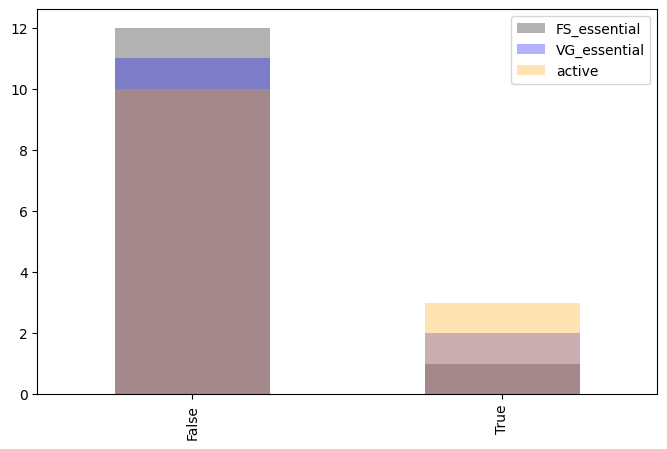

In [49]:
print(len(confirmed_depletions))
# None of them are essential
fig, ax = plt.subplots(figsize=(8,5))
res_df.loc[confirmed_depletions]['FS_essential'].value_counts().plot.bar(ax=ax,color='k',alpha=0.3)
res_df.loc[confirmed_depletions]['VG_essential'].value_counts().plot.bar(ax=ax,color='b',alpha=0.3)
res_df.loc[confirmed_depletions]['active'].value_counts().plot.bar(ax=ax,color='orange',alpha=0.3)
plt.legend()
plt.savefig('./figures/confirmed_gene_interdependence_stats_transport.svg',format='SVG')

In [50]:
df = res_df.loc[confirmed_depletions]
df[df['in_model']==False].shape[0]

4

In [51]:
res_df[res_df['in_model']==False].shape[0]

29

In [52]:
res_df.shape

(89, 6)

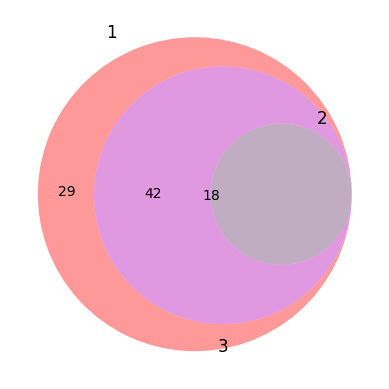

In [53]:
from matplotlib_venn import venn2,venn3
df = res_df
plt.rcParams['svg.fonttype'] = 'none'
df1 = set(df.index)
df2 = set(df[df['active']==True].index)
df3 = set(df[df['in_model']==True].index)
venn3([df1,df2,df3],('1','2','3'))
plt.savefig('./figures/venn_essential_active_model_known_spoAQ.svg',format='SVG')

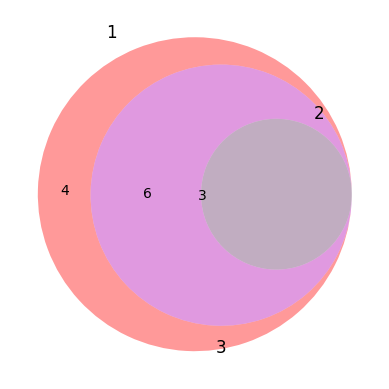

In [54]:
from matplotlib_venn import venn2,venn3
df = res_df.loc[confirmed_depletions]
plt.rcParams['svg.fonttype'] = 'none'
df1 = set(df.index)
df2 = set(df[df['active']==True].index)
df3 = set(df[df['in_model']==True].index)
venn3([df1,df2,df3],('1','2','3'))
plt.savefig('./figures/venn_essential_active_model_confirmed_spoAQ.svg',format='SVG')

## Interdependence stats

<AxesSubplot:ylabel='Frequency'>

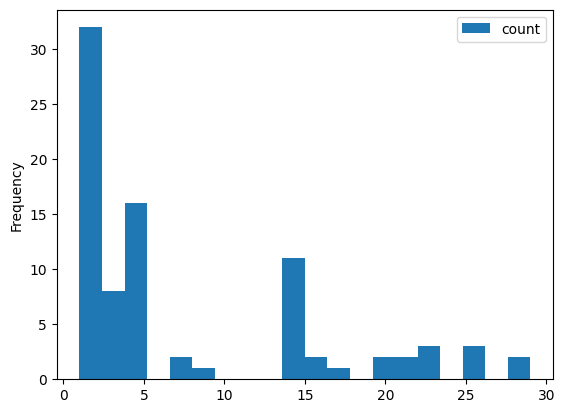

In [55]:
d = {}
for i,l in fwd_name_dep.items():
    d[i] = len(l)
tmp = pd.DataFrame.from_dict({"count":d}).sort_values("count")
tmp[tmp>0].plot.hist(bins=20)

## Backward interdependence

In [59]:
# importing networkx
import networkx as nx
# importing matplotlib.pyplot
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
G = nx.DiGraph()

for i in res_df[res_df['in_model']==True].index:
    dep_genes = name_dep[i]
    for j in dep_genes:
        if j==i: continue
        G.add_edge(j,i)

In [60]:
color_map = []
degree = []
labels = {}
for node in G:
    d = len(name_dep[node])
    degree.append(d)
    name = locus_to_name[node] if node in locus_to_name else node
    if name in confirmed_depletions:
        color_map.append('green')
    elif name in res_df.index:
        color_map.append('blue')
    else: 
        color_map.append('gray')
#     if d > 5:
    labels[node] = locus_to_name[node] if node in locus_to_name else node

## Forward interdependence

In [61]:
# importing networkx
import networkx as nx
# importing matplotlib.pyplot
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
G = nx.DiGraph()

for i in res_df[res_df['in_model']==True].index:
    dep_genes = fwd_name_dep[i]
    for j in dep_genes:
        if j==i: continue
        G.add_edge(i,j)

In [62]:
color_map = []
for node in G:
    if node in confirmed_depletions:
        color_map.append('green')
    elif node in res_df.index:
        color_map.append('blue')
    else: 
        color_map.append('gray')      

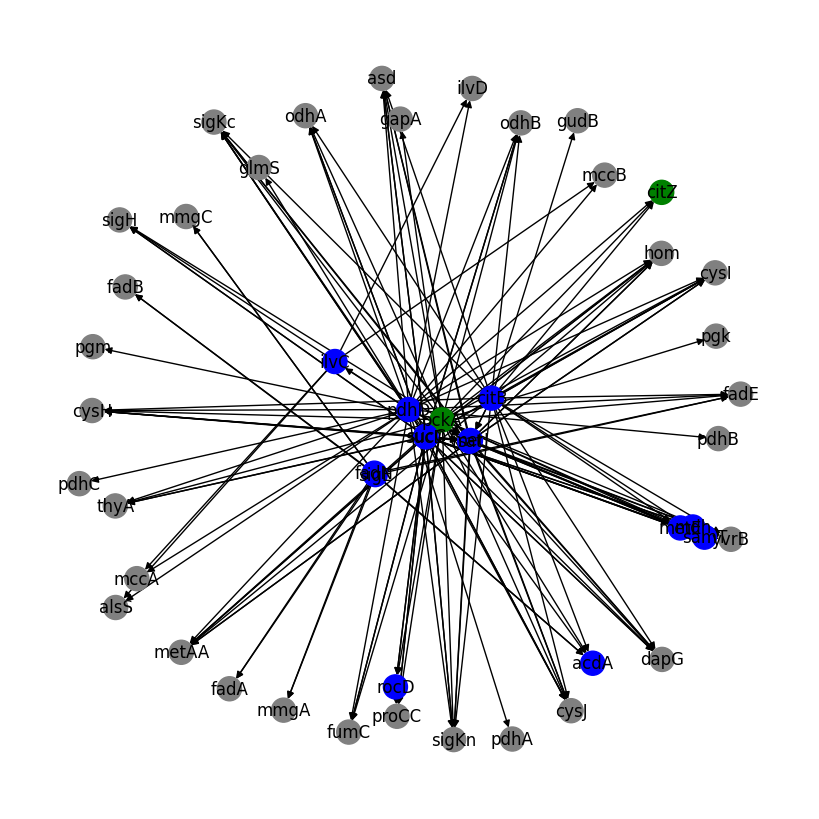

In [63]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(G, k=2.)
nx.draw(G,
#        pos=pos,
       with_labels = True,
#        node_size=2000,
#        arrowsize=20,
#        width = 1.5,
#        font_size=15,
       node_color=color_map
       )
# plt.savefig('./figures/network_gene_interdependence_spring_fwd_transport.svg',format='SVG')

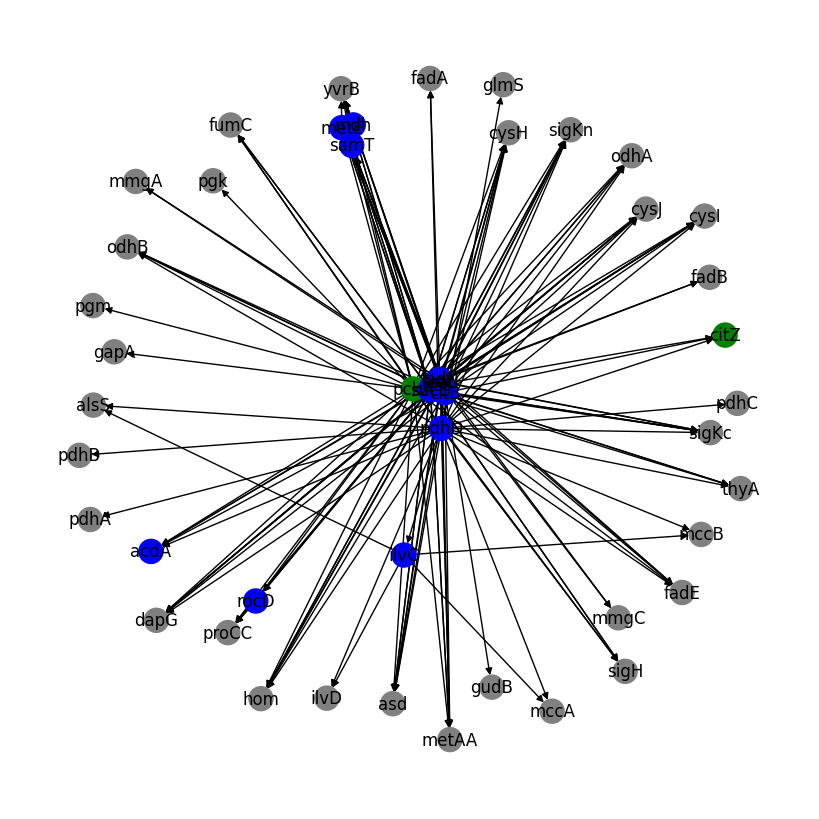

In [64]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(G, k=2.)
nx.draw(G,
#        pos=pos,
       with_labels = True,
#        node_size=2000,
#        arrowsize=20,
#        width = 1.5,
#        font_size=15,
       node_color=color_map
       )
# plt.savefig('./figures/network_gene_interdependence_spring_fwd_transport.svg',format='SVG')

## FWD and BWD interdependence

In [76]:
# importing networkx
import networkx as nx
# importing matplotlib.pyplot
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
G = nx.DiGraph()

for i in res_df[res_df['in_model']==True].index:
    dep_genes = name_dep[i]
    for j in dep_genes:
        if j==i: continue
        G.add_edge(j,i)

for i in res_df[res_df['in_model']==True].index:
    dep_genes = fwd_name_dep[i]
    for j in dep_genes:
        if j==i: continue
        G.add_edge(i,j)

In [77]:
color_map = []
degree = []
labels = {}
for node in G:
    d = len(fwd_id_dep[node])
    degree.append(d)
    name = locus_to_name[node] if node in locus_to_name else node
    if name in confirmed_depletions:
        color_map.append('green')
    elif name in res_df.index:
        color_map.append('blue')
    else: 
        color_map.append('gray')
    if d > 5:
        labels[node] = locus_to_name[node] if node in locus_to_name else node

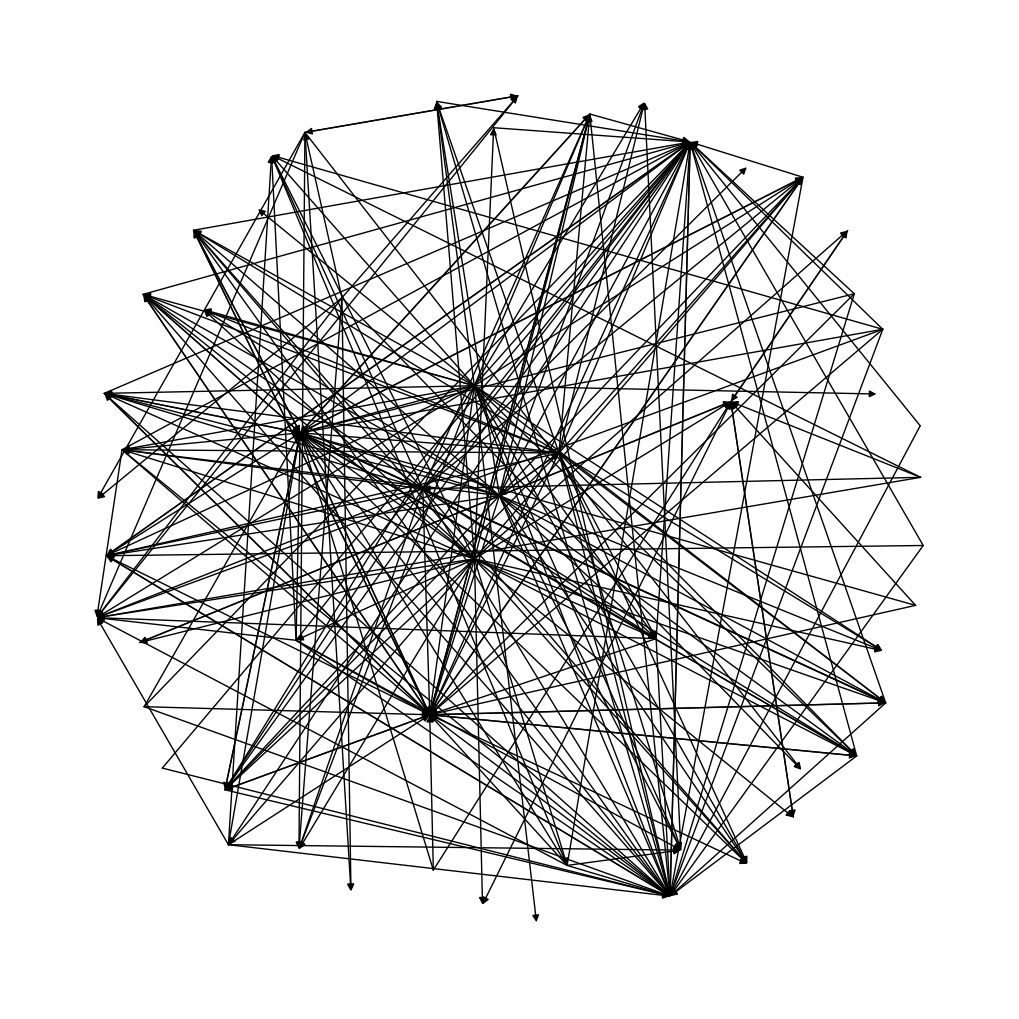

In [83]:
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k=2.)
nx.draw(G,
       pos=pos,
       node_color=color_map,
       node_size=[i for i in degree])
_ = nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='k')
# plt.savefig('./figures/network_gene_interdependence_spring_fwd_genome.svg',format='SVG')

In [68]:
color_map = []
for node in G:
    if node in confirmed_depletions:
        color_map.append('green')
    elif node in res_df.index:
        color_map.append('blue')
    else: 
        color_map.append('gray')      

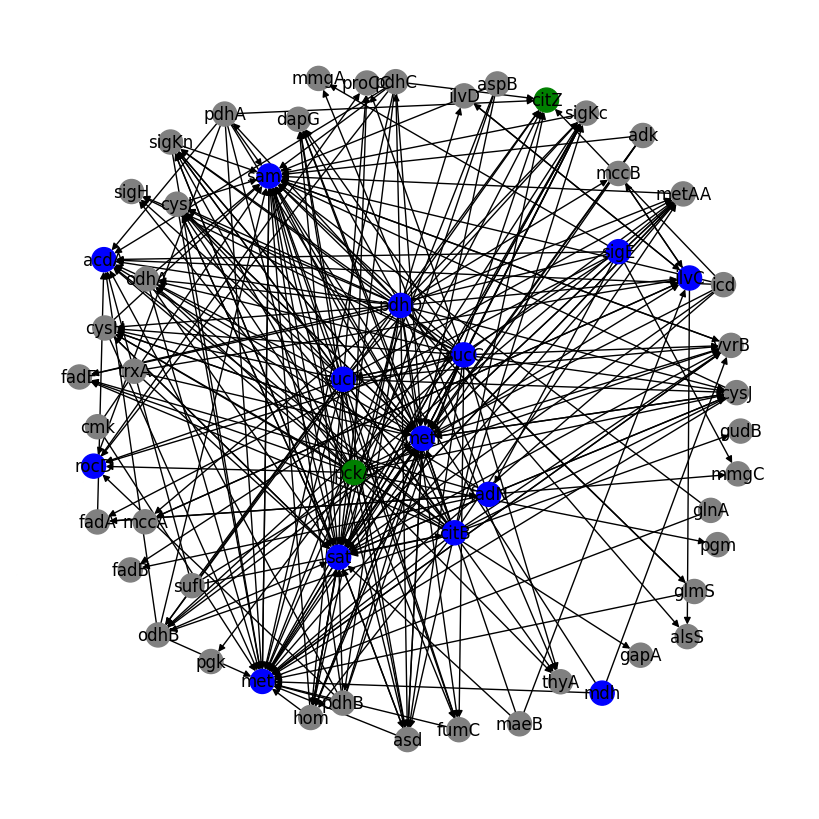

In [69]:
plt.figure(figsize=(8,8))
pos = nx.spring_layout(G, k=2.)
nx.draw(G,
       pos=pos,
       with_labels = True,
#        node_size=2000,
#        arrowsize=20,
#        width = 1.5,
#        font_size=15,
       node_color=color_map)
# plt.savefig('./figures/network_gene_interdependence_spring_fwd_bwd.svg',format='SVG')

## Subgraphs

In [70]:
def get_color_map(G):
    color_map = []
    degree = []
    labels = {}
    for node in G:
        d = len(fwd_name_dep[node])
        degree.append(d)
        name = locus_to_name[node] if node in locus_to_name else node
        if name in confirmed_depletions:
            color_map.append('green')
        elif name in known_depletions:
            color_map.append('blue')
        else: 
            color_map.append('gray')
    #     if d > 5:
        labels[node] = locus_to_name[node] if node in locus_to_name else node
    return color_map,degree,labels

subgraph 0 has 57 nodes
	Nodes: {'acdA', 'sucD', 'rocD', 'metI', 'fadB', 'gudB', 'sigKn', 'pgk', 'glmS', 'cysH', 'pgm', 'mmgA', 'glnA', 'cmk', 'sigH', 'adk', 'mccA', 'ilvD', 'pdhB', 'cysJ', 'thyA', 'pckA', 'metAA', 'fumC', 'mccB', 'citB', 'icd', 'sufU', 'pdhC', 'sigE', 'hom', 'alsS', 'pdhA', 'sat', 'asd', 'fadA', 'odhA', 'dapG', 'odhB', 'yvrB', 'fadN', 'mdh', 'proCC', 'citZ', 'mmgC', 'sucC', 'sigKc', 'cysI', 'trxA', 'ilvC', 'fadE', 'aspB', 'pdhD', 'metE', 'maeB', 'gapA', 'samT'}


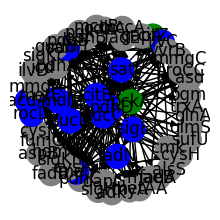

In [71]:
UG = G.to_undirected()
# extract subgraphs
sub_graphs = nx.connected_components(UG)

for i, sg in enumerate(sub_graphs):
    if not set(known_depletions) & sg: continue
    print ("subgraph {} has {} nodes".format(i, len(sg)))
    print ("\tNodes:", sg)
    SG = G.subgraph(sg)
    color_map,degree,labels = get_color_map(SG)
    if len(SG.nodes) > 4:
        plt.figure(figsize=(2,2))
    else:
        plt.figure(figsize=(1,1))
        
        
    pos = nx.spring_layout(SG, k=2.0)
    nx.draw(SG,
           pos=pos,
           with_labels = True,
    #        node_size=[i*50 for i in degree],
    #        arrowsize=20,
    #        width = 1.5,
    #        font_size=15,
           node_color=color_map
           )
#     plt.savefig('figures/network_sg_{}_spoAQ.svg'.format(i),format='SVG')

## Genome-scale interdependence

In [210]:
# importing networkx
import networkx as nx
# importing matplotlib.pyplot
import matplotlib.pyplot as plt
plt.rcParams['svg.fonttype'] = 'none'
G = nx.DiGraph()

for i in sporeme.genes:
    i = i.id
    i = locus_to_name[i]
    dep_genes = fwd_name_dep[i]
#     if len(dep_genes) < 30: continue
    for j in dep_genes:
        if j==i: continue
        G.add_edge(i,j)
print(len(G.edges))

554


In [211]:
color_map = []
degree = []
labels = {}
for node in G:
    d = len(fwd_name_dep[node])
    degree.append(d)
    name = locus_to_name[node] if node in locus_to_name else node
    if name in confirmed_depletions:
        color_map.append('green')
    elif name in res_df.index:
        color_map.append('blue')
    else: 
        color_map.append('gray')
    if d > 5:
        labels[node] = locus_to_name[node] if node in locus_to_name else node

In [212]:
import json
d =nx.cytoscape_data(G)
with open('./cytoscape//genome_scale_interdependence_network.json','w') as f:
    json.dump(d,f)

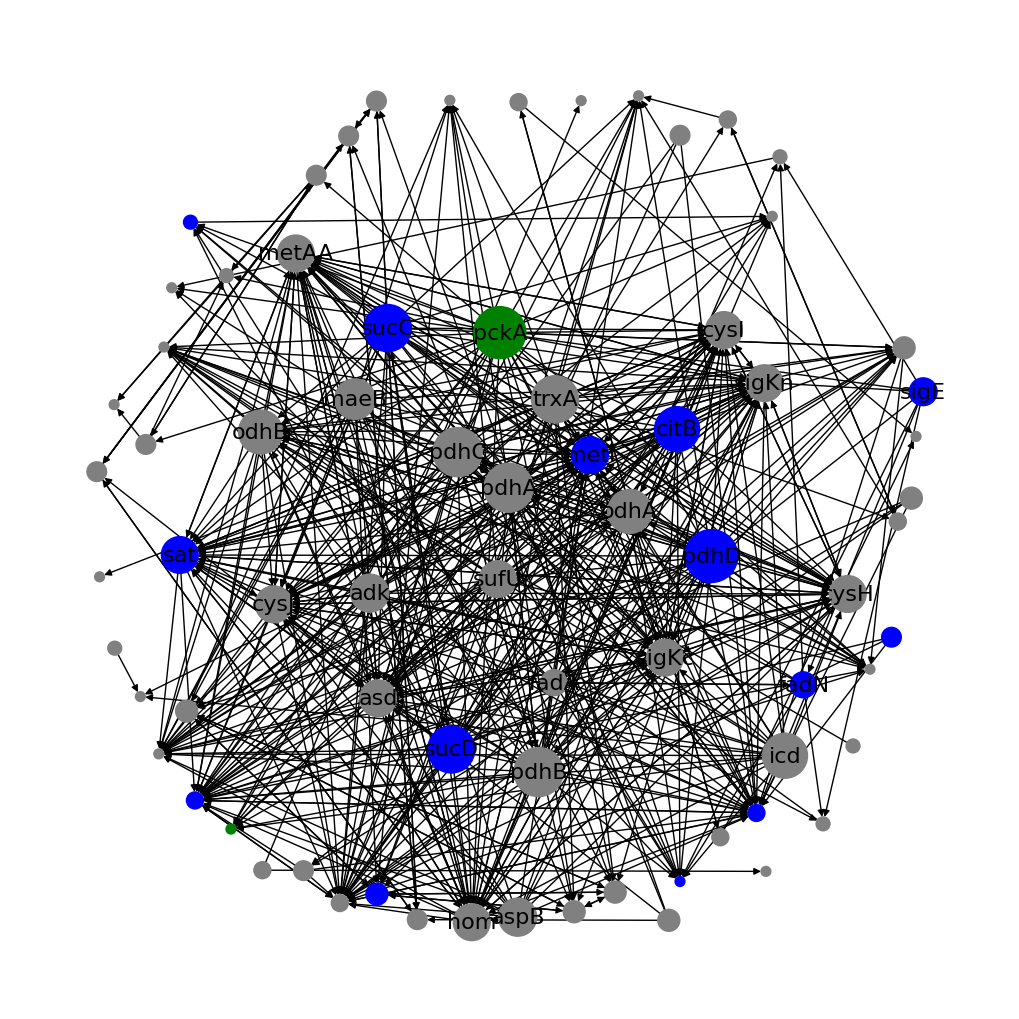

In [194]:
plt.figure(figsize=(10,10))
pos = nx.spring_layout(G, k=2.)
nx.draw(G,
       pos=pos,
       node_color=color_map,
       node_size=[i*50 for i in degree]
       )
_ = nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='k')
# plt.savefig('./figures/network_gene_interdependence_spring_fwd_genome.svg',format='SVG')

## One gene interdependence

In [258]:
def get_edges_from_gene(gene):
    edges = set()
    for j in fwd_name_dep[gene]:
        if j==gene: continue
        edges.add((gene,j))
    # for j in name_dep[gene]:
    #     if j==gene: continue
    #     edges.add((j,gene))
    return edges

def get_graph_from_gene(gene):
    import networkx as nx
    import matplotlib.pyplot as plt
    plt.rcParams['svg.fonttype'] = 'none'
    G = nx.DiGraph()
    edges = get_edges_from_gene(gene)
    for i,j in edges:
        G.add_edge(i,j)
    return G

In [259]:
G = get_graph_from_gene('ilvC')

In [260]:
color_map = []
degree = []
labels = {}
for node in G:
    d = len(fwd_name_dep[node])
    degree.append(d)
    name = locus_to_name[node] if node in locus_to_name else node
    if name in confirmed_depletions:
        color_map.append('green')
    elif name in res_df.index:
        color_map.append('blue')
    else: 
        color_map.append('gray')
#     if d > 5:
    labels[node] = locus_to_name[node] if node in locus_to_name else node

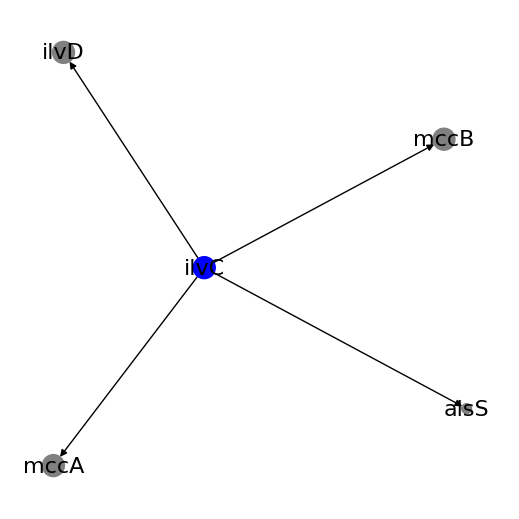

In [261]:
plt.figure(figsize=(5,5))
pos = nx.spring_layout(G, k=2.)
nx.draw(G,
       pos=pos,
       node_color=color_map,
       node_size=[i*50 for i in degree])
_ = nx.draw_networkx_labels(G,pos,labels,font_size=16,font_color='k')
plt.savefig('./figures/network_gene_interdependence_spring_fwd_{}_spoAQ.svg'.format(gene),format='SVG')

## Subgraphs

In [108]:
def get_edges_from_gene(gene):
    edges = set()
    for j in fwd_name_dep[gene]:
        if j==gene: continue
        edges.add((gene,j))
    for j in name_dep[gene]:
        if j==gene: continue
        edges.add((j,gene))
    return edges

def get_graph_from_gene(gene):
    import networkx as nx
    import matplotlib.pyplot as plt
    plt.rcParams['svg.fonttype'] = 'none'
    G = nx.DiGraph()
    edges = get_edges_from_gene(gene)
    for i,j in edges:
        G.add_edge(i,j)
    return G

In [109]:
def get_color_map(G):
    color_map = []
    degree = []
    labels = {}
    for node in G:
        d = len(fwd_name_dep[node])
        degree.append(d)
        name = locus_to_name[node] if node in locus_to_name else node
        if name in confirmed_depletions:
            color_map.append('green')
        elif name in known_depletions:
            color_map.append('blue')
        else: 
            color_map.append('gray')
    #     if d > 5:
        labels[node] = locus_to_name[node] if node in locus_to_name else node
    return color_map,degree,labels

subgraph 0 has 14 nodes
	Nodes: ['pdhD', 'acdA', 'pdhB', 'pdhA', 'sufU', 'citB', 'icd', 'odhB', 'fadA', 'pckA', 'odhA', 'pdhC', 'fadN', 'sigE']
subgraph 1 has 23 nodes
	Nodes: ['sucD', 'yvrB', 'samT', 'cysH', 'sigKn', 'thyA', 'sat', 'metI', 'cysJ', 'sucC', 'sigH', 'proCC', 'sigKc', 'cysI', 'odhB', 'metAA', 'odhA', 'metE', 'rocD', 'hom', 'asd', 'fumC', 'dapG']
subgraph 2 has 8 nodes
	Nodes: ['sucD', 'rocD', 'pdhB', 'pckA', 'proCC', 'pdhC', 'sucC', 'pdhA']
subgraph 3 has 29 nodes
	Nodes: ['sat', 'sigKc', 'cysI', 'odhB', 'cysH', 'samT', 'sucC', 'trxA', 'citB', 'metE', 'sigKn', 'metAA', 'asd', 'aspB', 'sucD', 'pdhD', 'dapG', 'cysJ', 'pckA', 'maeB', 'adk', 'metI', 'pdhB', 'hom', 'pdhC', 'icd', 'yvrB', 'pdhA', 'odhA']
subgraph 4 has 29 nodes
	Nodes: ['odhA', 'metI', 'sigKn', 'odhB', 'metAA', 'sucC', 'trxA', 'sigKc', 'cysI', 'metE', 'cysH', 'citB', 'samT', 'asd', 'aspB', 'sucD', 'pdhD', 'pckA', 'adk', 'cysJ', 'dapG', 'maeB', 'sat', 'hom', 'pdhC', 'icd', 'yvrB', 'pdhB', 'pdhA']
subgraph 5 has 

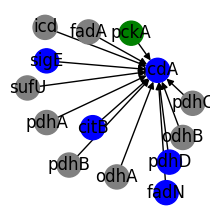

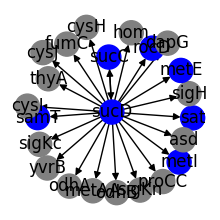

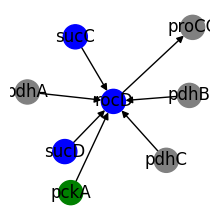

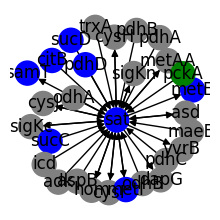

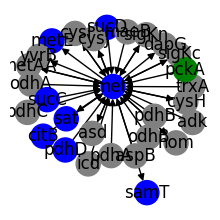

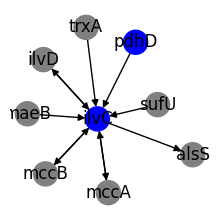

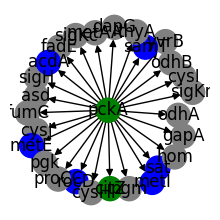

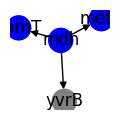

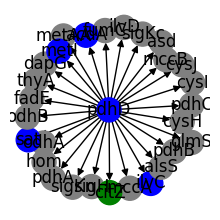

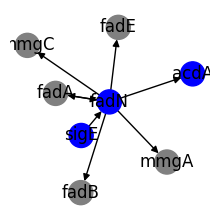

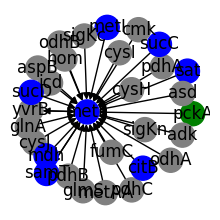

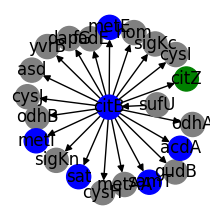

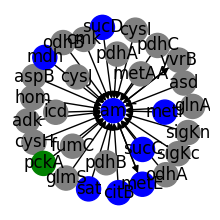

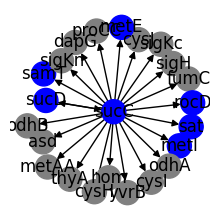

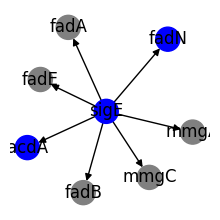

In [110]:
for i, gene in enumerate(set(known_depletions) & set(G.nodes)):
    SG = get_graph_from_gene(gene)
    print ("subgraph {} has {} nodes".format(i, len(SG.nodes)))
    print ("\tNodes:", SG.nodes)
    
    color_map,degree,labels = get_color_map(SG)
    if len(SG.nodes) > 4:
        plt.figure(figsize=(2,2))
    else:
        plt.figure(figsize=(1,1))
        
        
    pos = nx.spring_layout(SG, k=1.0)
    nx.draw(SG,
           pos=pos,
           with_labels = True,
    #        node_size=[i*50 for i in degree],
    #        arrowsize=20,
    #        width = 1.5,
    #        font_size=15,
           node_color=color_map
           )
    plt.savefig('figures/network_sg_{}_spoAQ.svg'.format(i),format='SVG')

## Histogram

In [351]:
d = {k:len(v) for k,v in fwd_name_dep.items()}

In [352]:
df = pd.DataFrame.from_dict({'influence':d})

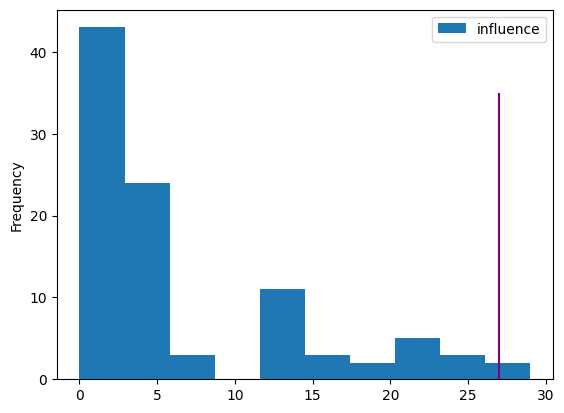

In [389]:
df.plot.hist(bins = 10)
plt.vlines(x=df.loc["pckA"]["influence"]-1,ymin=0,ymax=35,color='purple')
plt.savefig('./figures/pckA_inactivations.svg',format='SVG')

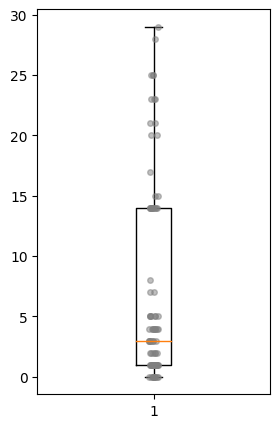

In [394]:
import random

fig,ax = plt.subplots(1,1,figsize=(3,5))
ax.boxplot(df["influence"])
for v in df["influence"].values:
    plt.plot(1+random.uniform(-1, 1)/50,v,'o',color='gray',alpha=0.5,markersize=4)
plt.savefig('./figures/inactivations_boxplot.svg',format='SVG')

In [392]:
df["influence"].sort_values()

yxbC     0
acoC     0
acsA     0
hpf      0
ilvB     0
        ..
pdhA    25
pdhC    25
pdhB    25
pckA    28
pdhD    29
Name: influence, Length: 96, dtype: int64

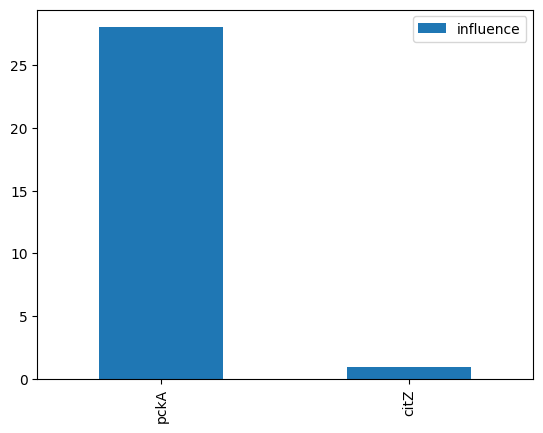

In [347]:
df1 = df.loc[[i for i in known_depletions if i in df.index]].sort_values('influence',ascending=False)
df1[df1['influence'] > 0].plot.bar()
plt.savefig('bar_inactivated.svg',format='SVG')

## Heatmap

In [ ]:
locus_to_name = pd.read_csv('../gene_name_dictionary.csv',index_col=0)['name'].to_dict()
name_to_locus = pd.read_csv('../gene_name_dictionary.csv',index_col=1)['locus_id'].to_dict()

In [ ]:
known_depletions = [g[0].lower() + g[1:] for g in list(pd.read_csv('proteomics/known_depletions.txt')['protein'].values)]

In [ ]:
df = pd.read_csv('essentiality_raw_results_naive_FS_transport_spoAQ.csv',index_col=0).T
translation = df[[i for i in df.columns if re.search('translation_.*_s',i)]].T
translation = translation[translation['base']>cutoff].T

In [ ]:
from tqdm import tqdm
import seaborn as sns
from scipy.stats import zscore

In [ ]:
expression = {}
for i,row in tqdm(translation.iterrows(),total=translation.shape[0]):
    i = i.split('_s')[0]
    iname = locus_to_name[i] if i in locus_to_name else i
    expression[iname] = {}
    for j,val in row.items():
        j = j.split('translation_')[1].split('_s')[0]
        jname = locus_to_name[j] if j in locus_to_name else j
        expression[iname][jname] = val
expression = pd.DataFrame.from_dict(expression).drop('dummy')

In [ ]:
depletions_in_model = [i for i in known_depletions if i in expression.index]

In [ ]:
log_expression_all = np.log10(expression[depletions_in_model + ['base']]+1e-16)
log_expression_known = np.log10(expression.loc[depletions_in_model][depletions_in_model + ['base']]+1e-16)

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(log_expression_known.T,
           vmin = -1,
           vmax = -16)

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap((expression>0.).loc[depletions_in_model][depletions_in_model + ['base']])


In [ ]:
df = expression.loc[depletions_in_model]
induced_inactivation_of_known = df.T.loc[(df==0).any()].T
plt.figure(figsize=(20,10))
sns.clustermap(induced_inactivation_of_known.T>0,
              figsize=(20,10))

In [ ]:
df = expression.loc[depletions_in_model].T
inactivated_by_known = df.T.loc[(df==0).any()].T
plt.figure(figsize=(20,10))
sns.clustermap(inactivated_by_known>0,
              figsize=(20,10))

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap((expression>0.)[depletions_in_model])

In [ ]:
plt.figure(figsize=(20,5))
df = (expression==0.).sum()
df[df>0].sort_values().plot.bar()

In [ ]:
sns.clustermap(log_expression_known,
              figsize=(10,10))

In [ ]:
sns.clustermap(log_expression_all,
              figsize=(5,20))